# Mel-Spectrograms

__Library__

In [61]:
import math
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display

from tqdm import tqdm
from scipy.io import wavfile

from torch.utils.data import Dataset, DataLoader

__display__

In [48]:
file = 'audio/izanamikyouko_1.wav'
ipd.Audio(file)

__sample__

In [92]:
# loading
sample, rate = librosa.load(file, sr=rate)

# padding & trimming
sampe1 = librosa.util.fix_length(sample, size = 10*rate)

# write
wavfile.write('sample.wav', data = sampe1, rate = rate)

## Mel Spectrogram

In [87]:
df = pd.DataFrame({'file':['audio/debussy.wav', 'audio/voice.wav', 'audio/izanamikyouko_1.wav'], 'label':[0, 1, 2]}, columns=['file','label'])
df

,file,label
0,audio/debussy.wav,0
1,audio/voice.wav,1
2,audio/izanamikyouko_1.wav,2


In [88]:
class MelSpecDataset(Dataset):
    def __init__(self, df, sec = 5, sr = 22050, n_fft = 2048, hop_length=512, n_mels = 90):
        self.files = []
        self.X = []
        self.y = []
        
        self.size = sec*sr
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        
        self.shape = (self.n_mels, math.floor(self.size/self.hop_length) + 1)

        for index, row in tqdm(df.iterrows(), total=df.shape[0]):
            
            # load audio
            file = row['file']
            sample, _ = librosa.load(row['file'], sr = self.sr)
            
            # segment
            for seg in range(math.ceil(len(sample)/self.size)):
                
                segment = sample[self.size*seg:self.size*(seg+1)]
                
                if len(segment) > self.size * 0.6:
                    segment = librosa.util.fix_length(segment, size = self.size)
                
                    # extract mel-spectrogram
                    mel_spec = self.mel_spectrogram(segment)
                    mel_spec_norm = self.normalize(mel_spec)

                    # label
                    self.files.append(file)
                    self.X.append(mel_spec_norm)
                    self.y.append(row['label'])
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def mel_spectrogram(self, sample):
        mel_spec = librosa.feature.melspectrogram(sample, sr = self.sr, n_fft = self.n_fft, hop_length=self.hop_length, n_mels = self.n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, top_db = 80.0)
        return log_mel_spec
    
    def normalize(self, spec, eps=1e-6):
        mean = spec.mean(); std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
#         spec_min, spec_max = spec_norm.min(), spec_norm.max()
#         spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
#         spec_scaled = spec_scaled.astype(np.uint8)
        return spec_norm
    def plot(self, index):
        plt.figure(figsize=(15,8))
        librosa.display.specshow(self.X[index], x_axis = 'time', y_axis = 'mel', sr = self.sr)
        plt.title('Mel-Spectrogram, label:{}, file:{}'.format(self.y[index],self.files[index]))
        plt.colorbar(format='%+2.f')
        plt.show()
train_ds = MelSpecDataset(df)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

# valid_ds = MelSpecDataset(df)
# valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.37it/s]


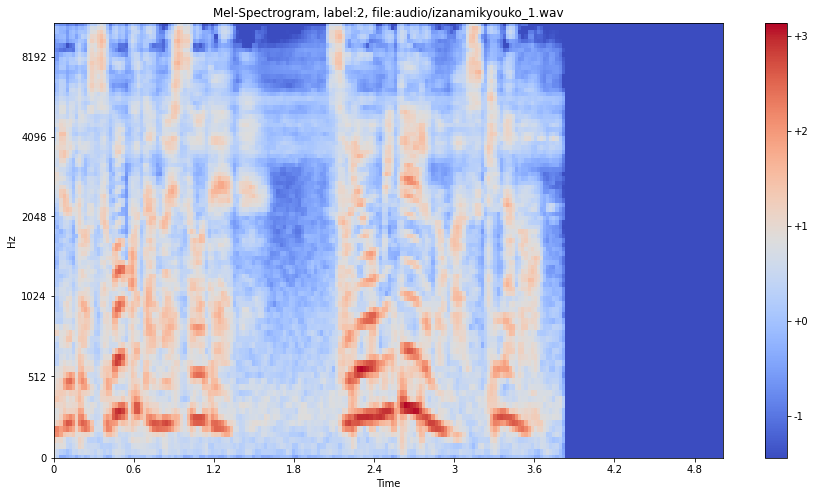

In [91]:
train_ds.plot(13)